# Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles
# Make 100 Samples
n_samples = 10000
X,y = make_circles(n_samples,noise=0.125,random_state=42)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
X[:5],y[:5]

(array([[ 0.19998864,  0.90325107],
        [ 1.26750313, -0.58094471],
        [-0.63155772,  0.70494095],
        [ 1.10157297, -0.34613108],
        [ 0.84793432, -0.48702293]]),
 array([1, 0, 0, 0, 0]))

In [4]:
# Make a DataFrame of circle data
import pandas as pd

In [5]:
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"y":y})

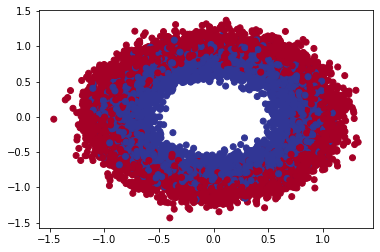

In [6]:
# Visualizing
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [7]:
X_sample = X[0]
y_sample = y[0]
X_sample,y_sample,X_sample.shape,y_sample.shape

(array([0.19998864, 0.90325107]), 1, (2,), ())

### Data -> Tensors + Train and Test Split

In [8]:
# Turn data into tensors
import torch
torch.__version__

'1.9.1'

In [9]:
X.dtype

dtype('float64')

In [10]:
X = torch.from_numpy(X).type(torch.float32).to(device)
y = torch.from_numpy(y).type(torch.float32).to(device)

In [11]:
X[:2],y[:2]

(tensor([[ 0.2000,  0.9033],
         [ 1.2675, -0.5809]], device='cuda:0'),
 tensor([1., 0.], device='cuda:0'))

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [14]:
len(X_train),len(y_test)

(7500, 2500)

## Building the moel

Let's build a mopdel to classify our blue and red dots

To do so, we want to:

1. Setup device agnositic code so our code will run on an GPU/TPU
2. Contruct the model (by subclassing nn.Module)
3. Define the loss function and optimizer
4. the training loop
5. the testing loop

In [15]:
import torch
from torch import nn

# Make device agnositic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
device

'cuda'

Now we've setup device agnositc code, let's create a model that:
1. Subclass `nn.Module`
2. Create 2 `nn.Linear` layers
3. Create forward pass()
4. Create a instance of our model and send it to the device (gpu)

higher the no. of features the higher the number of weights and biases that can be changed overtime by backproagration which will give much more drastic acurrate change in the output given

In [17]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2,1024) # 
        self.layer_2 = nn.Linear(1024,1)
    
    def forward(self,X):
        return self.layer_2(self.layer_1(X)) # x -> layer_1 -> layer_2

In [18]:
model_0 = CircleModelV0().to(device)

In [19]:
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=1, bias=True)
)

In [20]:
list(model_0.parameters())

[Parameter containing:
 tensor([[ 0.0397, -0.2057],
         [-0.3409, -0.1964],
         [ 0.3998, -0.5351],
         ...,
         [ 0.0329, -0.1262],
         [ 0.3635, -0.0037],
         [-0.2986, -0.4017]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.6824, -0.3856, -0.5077,  ..., -0.2906,  0.2728, -0.6431],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0185, -0.0038,  0.0112,  ..., -0.0084, -0.0060, -0.0152]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0002], device='cuda:0', requires_grad=True)]

In [21]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=64),
    nn.Linear(64,1)
).to(device)

In [22]:
untrained_preds = model_0(X_test)

In [23]:
untrained_preds[0],y_test[0]

(tensor([-0.2167], device='cuda:0', grad_fn=<SelectBackward>),
 tensor(1., device='cuda:0'))

### Setup loss function and optimizer

Which criterion or optimizer should we use?

This is problem specific 

For regression we use MAE or MSE

For classification we want binary crossentropy or cateogrical cross entropy

And for optimizers, two of the most commen and useful are SGD and Adam

In [24]:
loss_fn = nn.BCEWithLogitsLoss() # has the sigmoid function builtin
# BCELoss() requries sigmoid to be builtin to the model itself

In [25]:
optimizer = torch.optim.SGD(model_0.parameters(),lr=0.01)

In [26]:
epochs = 100
batch_size = 32

In [27]:
# Calculate accuracy
def accuracy_fn(y_true,y_preds):
    correct = torch.eq(y_true,y_preds).sum().item() # gives a False True list -> Tensor no. of true > just normal no.
    acc = correct/len(y_preds)*100
    return acc

# Train Loss

1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss Backward
5. Optimizer step